# Alura - Imersão de Dados - Aula 2

<p>Nessa aula será utilizado o DataSet de imóveis de São Paulo, obtido do Kaggle, e iremos tentar resolver alguns problemas:</p>

<ol>
    <li>Criar uma escala de valores em milhões;</li>
    <li>Preço do metro quadrado por bairro e plotar em um gráfico ideal;</li>
    <li>Pesquisar um visualização para analisar os quartis, mediana e outliers.</li>
</ol>

<p>O foco dessa aula será começar o processo de tratamento de dados e usar o seaborn para visualização de dados.</p>

In [252]:
#Importando bibliotecas importantes
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
#sns.set(style = "white")
from colorsys import hls_to_rgb #Para cores!
from scipy import stats #Para tratamento os outliers que irão aparecer.

In [238]:
#Uma função para retornar "DESCONHECIDO" para quando eu achar algo NaN em certa coluna. O objetivo dessa
#função é ser aplicada aos bairros/ruas.
def retornoDesc(INDEX,LISTA_NULOS,DF_RETORNO,COLUNA):
    for i in INDEX:
        if LISTA_NULOS[i]:
            DF_RETORNO[COLUNA].loc[i] = "Desconhecido"
    return DF_RETORNO

#Uma função para fazer gráficos em barras. Aqui ela apenas faz com que os valores de cada barra sejam 
#postos em cima de sua respectiva barra. Qualquer outra alteração extra no gráfico deve ser feita de
#maneira separada.
def grap_retorno(VAL_X,VAL_Y,ARG_FONTE=20,ARG1_COR=0.2,ARG2_COR=1,RAN1=20,RAN2=30):
    cor = [(hls_to_rgb(i/(4*len(VAL_Y)),ARG1_COR,ARG2_COR)) for i in range(RAN1,RAN2)]
    ax = plt.bar(VAL_X,VAL_Y, color=cor)
    for val in ax:
        alt = val.get_height()
        plt.text(val.get_x() + val.get_width() / 2.0 ,alt,f'{alt: .0f}',ha="center",va="bottom", fontsize=ARG_FONTE)
    return ax 

In [239]:
#Caminho dos dados
path = 'https://gist.githubusercontent.com/tgcsantos/3bdb29eba6ce391e90df2b72205ba891/raw/22fa920e80c9fa209a9fccc8b52d74cc95d1599b/dados_imoveis.csv'

In [240]:
DF_or = pd.read_csv(path) #Leio o arquivo CSV
DF_or

,Rua,Bairro,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor
0,"Avenida Itacira, 255",Planalto Paulista,São Paulo,1000,4,8,6,R$ 7.000.000
1,"Rua Aurelia Perez Alvarez, 42",Jardim dos Estados,São Paulo,496,4,4,4,R$ 3.700.000
2,Rua Alba Valdez,Jardim Reimberg,São Paulo,125,4,3,2,R$ 380.000
3,NaN,Jardim Morumbi,São Paulo,310,3,2,4,R$ 685.000
4,"Rua Tobias Barreto, 195",Mooca,São Paulo,100,3,2,2,R$ 540.000
...,...,...,...,...,...,...,...,...
10003,Rua Tapuçu,Vila Sofia,São Paulo,95,2,2,2,R$ 665.000
10004,Rua Guararema,Bosque da Saúde,São Paulo,605,8,7,5,R$ 2.300.000
10005,Rua Estero Belaco,Vila da Saúde,São Paulo,205,3,3,6,R$ 1.050.000
10006,"Rua Manuel Onha, , 514",Vila Oratório,São Paulo,185,3,2,2,R$ 2.200\n /Mês


### Primeiro Problema:

<p>O primeiro problema envolve "arrumar" a tabela de valor para ficar apenas como um número "bruto".</p>

In [241]:
DF_copia = DF_or.copy()

#"Dropo" os bairros "nulos" e retorno eles como desconhecido
lista_index = DF_copia["Bairro"].index #Lista de índices
lista_nulos_bai = DF_copia["Bairro"].isnull()  #Lista de bairros nulos
lista_nulos_rua = DF_copia["Rua"].isnull()
DF_copia = retornoDesc(lista_index, lista_nulos_rua, DF_copia, "Rua")
DF_copia = retornoDesc(lista_index, lista_nulos_bai, DF_copia, "Bairro")

#Garante que na coluna 0 tem apenas o cifrão.
print(DF_copia["Valor"].str.split(expand = True)[0].unique()) 

#Altero o dataframe pra conter tudo existente no split.
#A coluna "Moeda" é puramente o cifrão.
#A coluna "Valor_Bruto" é o valor da casa, seja ela a venda ou o aluguel dela.
#A coluna "Tipo" envolve se a casa está a venda ou é de aluguel.
DF_copia[["Moeda","Valor_Bruto","Tipo"]] = DF_copia["Valor"].str.split(expand = True) 

#Jogo fora valores não nulos de dentro da tabela, isso permitirá retirar o preço de alugueis!
#Devemos ter em mente que esse método leva em consideração o fato de que os dados de aluguel foram 
#adicionados aos dados, caso tenha sido "13 mil reais por ano" mas sem o "por ano".
DF_copia = DF_copia[DF_copia["Tipo"].isnull()] 

#Jogo fora a tabela de tipo e de moeda, afinal de contas a única coisa que me restou foram as casas
#Que estão a venda e sabemos que a moeda aceita é o Real.
DF_copia.drop(labels=["Tipo","Moeda"], axis=1, inplace=True)

#Por fim, crio uma separaçãoo dos valores em Valor_Bruto e escrevo eles de forma "inteira", em seguida
#altero o tipo de dado para float64.
DF_copia["Valor_Bruto"] = DF_copia["Valor_Bruto"].str.replace('.',"").astype("float64")

#Agora que mudei o formato do Valor_Bruto, posso tentar retirar os dados de aluguel "restantes" do
#primeiro expurgo feito ali em cima. Aqui, vou colocar como "valor de corte" o preço de 48 mil reais
#pelo simples fato de que na minha pobre cabeça ninguém pagará 4 mil reais por mês de aluguel ou 48 mil
#reais por ano para uma casa que essa pessoa não é dona ou não está comprando.
DF_copia = DF_copia[DF_copia["Valor_Bruto"]>48000.0]

#E agora, crio uma escala em milhões dos preços das casas:
DF_copia["Valor_Bruto_Milhoes"] = DF_copia["Valor_Bruto"]/1000000

#Dropo o que tiver mais de 10 quartos, que nesse caso vou supor que é uma república e não serão usadas
#na análise.
DF_copia = DF_copia[DF_copia["Quartos"]<10]

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


['R$']


<ipython-input-241-4aa80678912c>:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  DF_copia["Valor_Bruto"] = DF_copia["Valor_Bruto"].str.replace('.',"").astype("float64")


In [242]:
DF_copia.describe()

,Metragem,Quartos,Banheiros,Vagas,Valor_Bruto,Valor_Bruto_Milhoes
count,9137.000000,9137.000000,9137.000000,9137.000000,9.137000e+03,9137.000000
mean,434.358652,3.432089,3.792273,3.956222,3.053493e+06,3.053493
std,7864.576775,0.989664,1.964208,2.598339,3.946039e+06,3.946039
min,10.000000,1.000000,1.000000,1.000000,1.300000e+05,0.130000
25%,168.000000,3.000000,2.000000,2.000000,8.900000e+05,0.890000
50%,275.000000,3.000000,4.000000,4.000000,1.800000e+06,1.800000
75%,450.000000,4.000000,5.000000,5.000000,3.500000e+06,3.500000
max,750000.000000,9.000000,40.000000,50.000000,6.500000e+07,65.000000


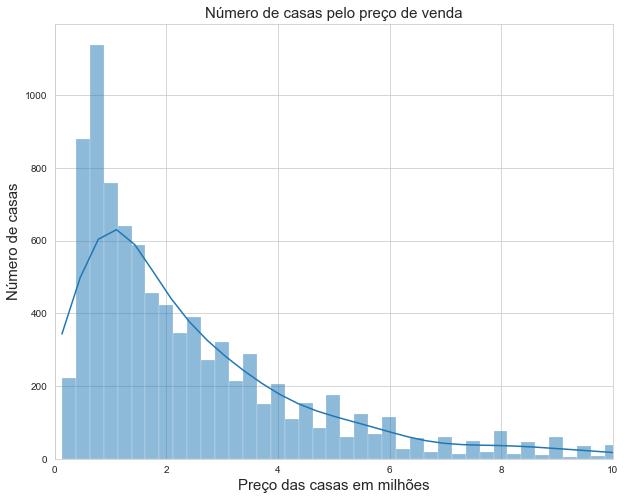

In [243]:
fonte = {"size": 15}
sns.set_style("whitegrid")
plt.figure(figsize=(10,8))
paleta = list(sns.color_palette("rocket"))
sns.histplot(data = DF_copia, x = "Valor_Bruto_Milhoes", kde=True, palette = paleta)
plt.title("Número de casas pelo preço de venda", fontdict = fonte)
plt.xlabel("Preço das casas em milhões", fontdict = fonte)
plt.ylabel("Número de casas", fontdict = fonte)
plt.xlim((-50/1000000, 10))
plt.show()

In [244]:
#Obtenho o preço médio por bairro:
DF_copia_PM_PB = DF_copia.groupby(["Bairro"]).mean()["Valor_Bruto"]/100000
DF_copia_PM_PB.sort_values(ascending=False, inplace=True)

#Obtenho uma parte do top10
DF_copia_PM_PB_t10 = DF_copia_PM_PB.head(10)

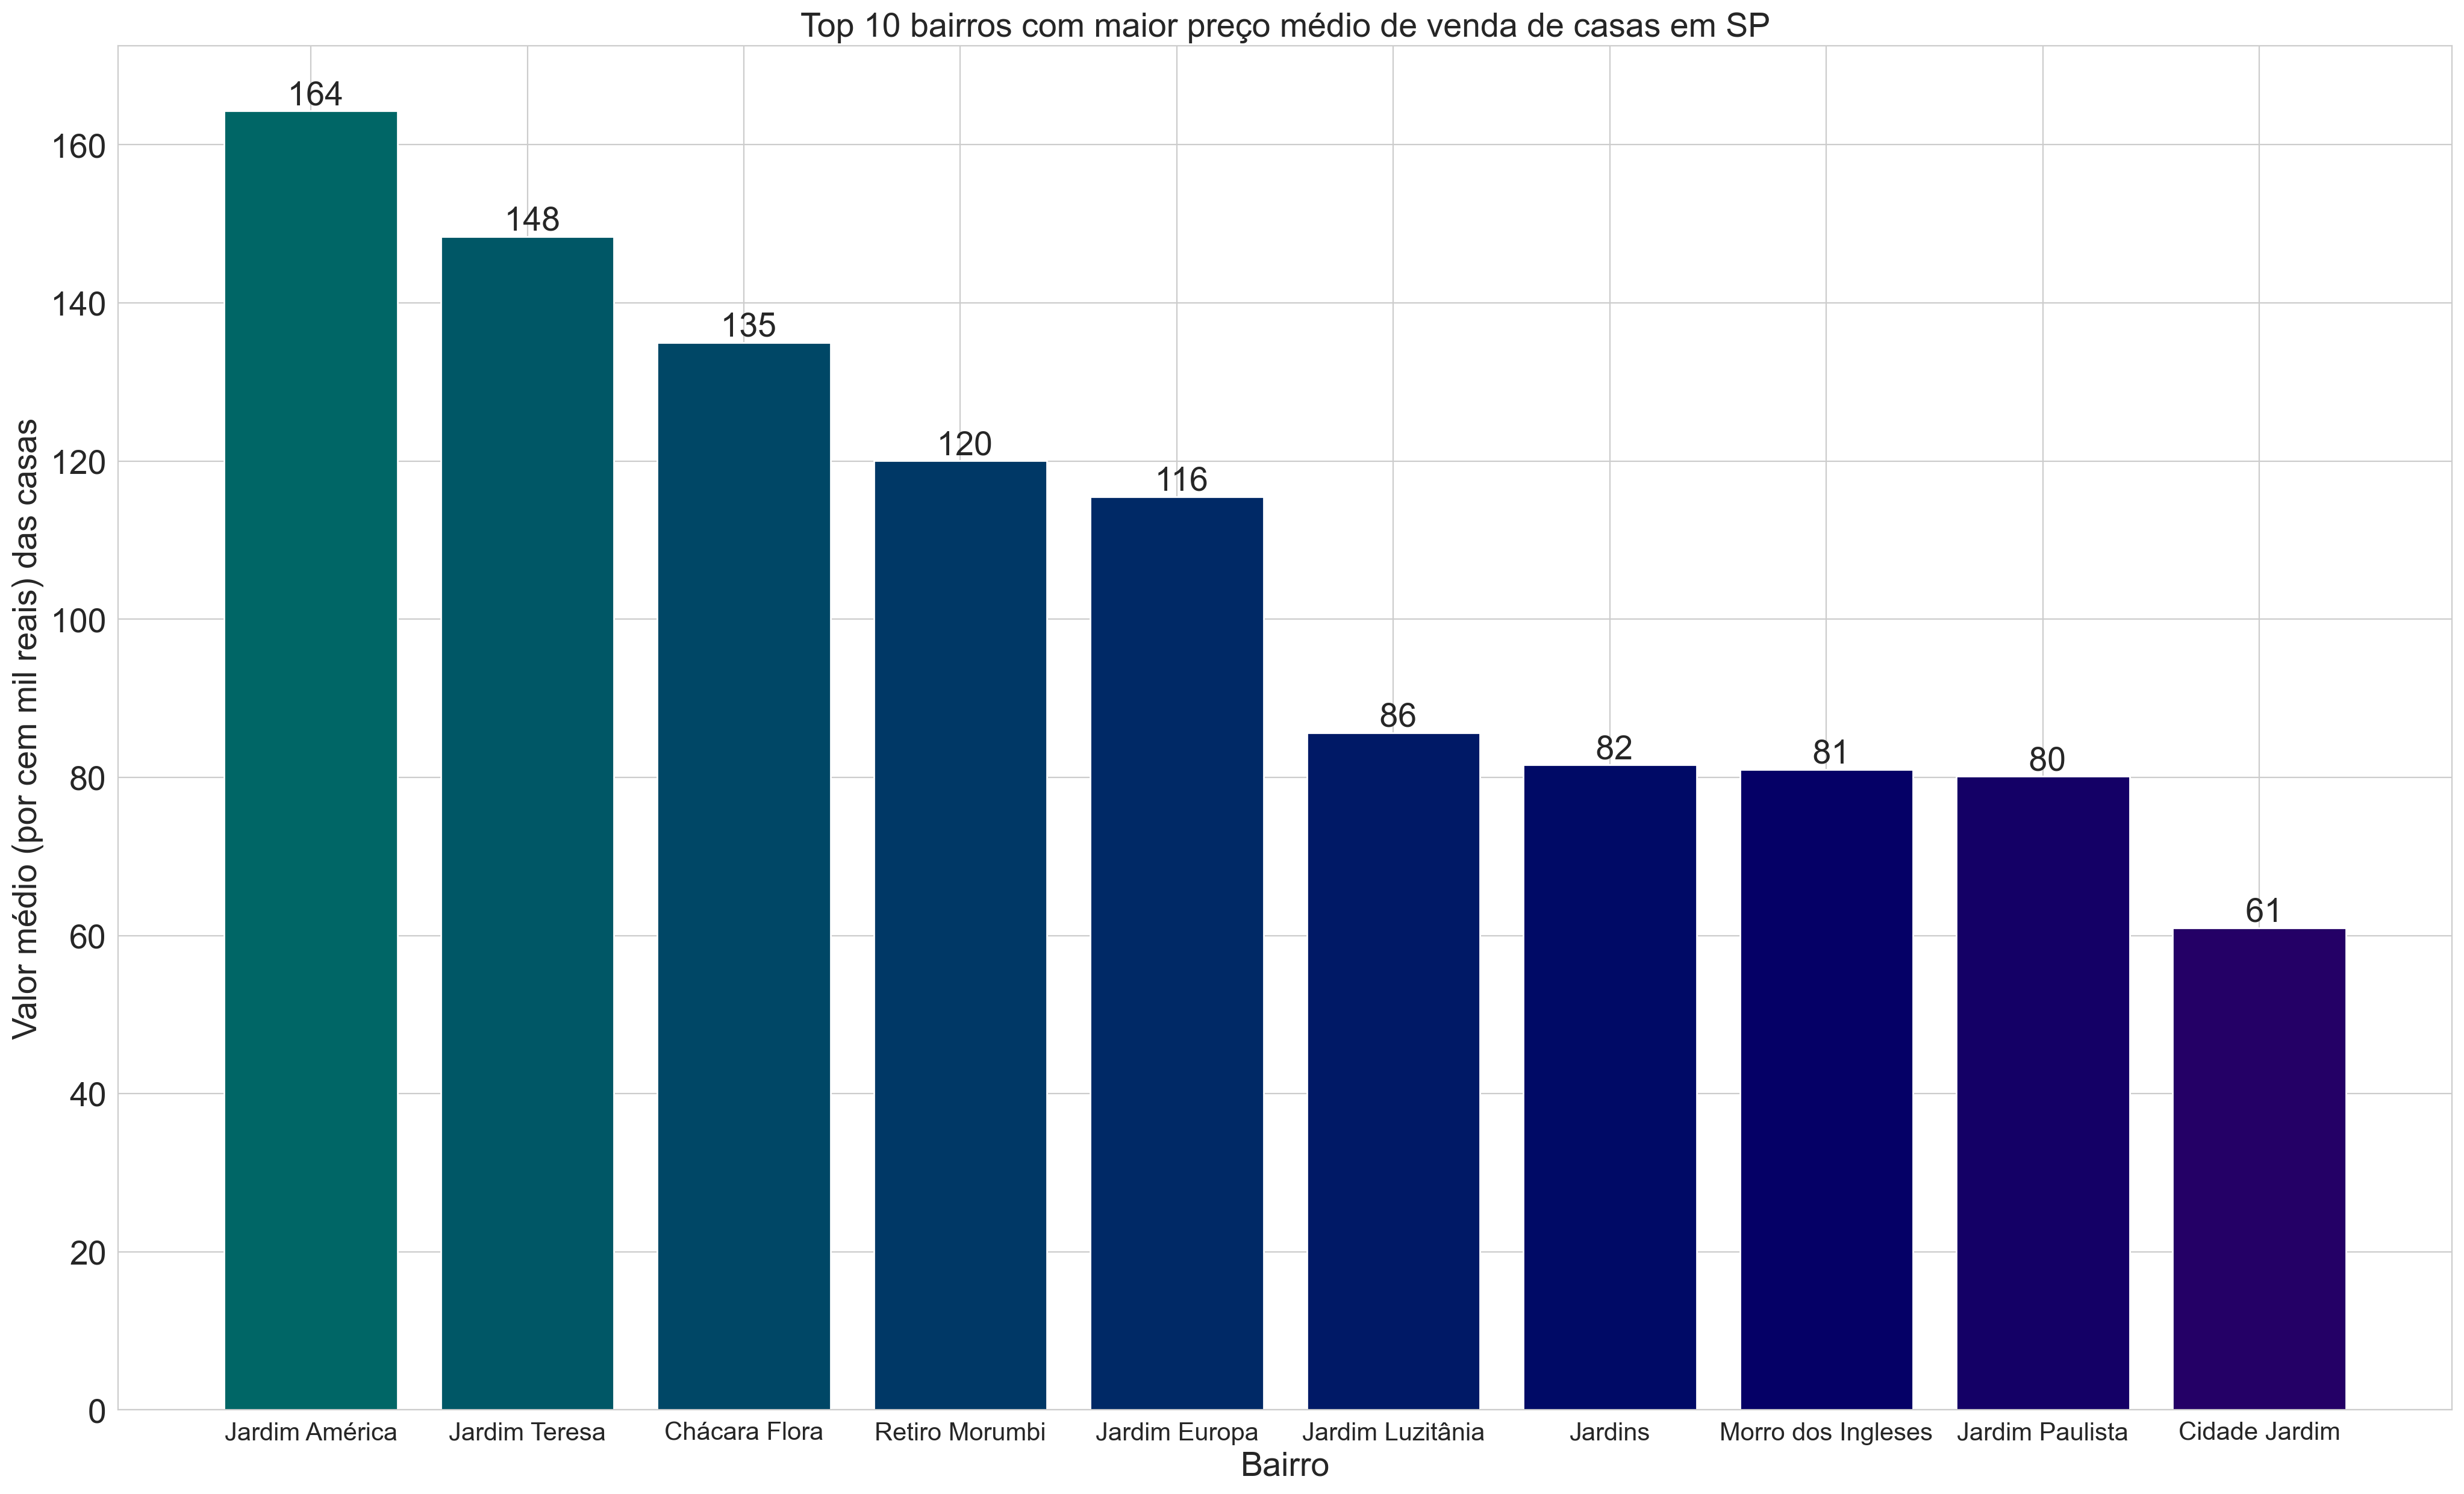

In [245]:
fonte = {"size":20}
plt.figure(figsize=(25,15),dpi=200)
grap = grap_retorno(VAL_X=DF_copia_PM_PB_t10.index,VAL_Y=DF_copia_PM_PB_t10)
plt.title("Top 10 bairros com maior preço médio de venda de casas em SP", fontdict=fonte)
plt.xlabel("Bairro",fontdict=fonte)
plt.xticks(fontsize=15)
plt.ylabel("Valor médio (por cem mil reais) das casas",fontdict=fonte)
plt.yticks(fontsize=20)
plt.show()

### Segundo Problema:

<p>Obter o preço por metro quadrado dos bairros de São Paulo e depois plotá-los.</p>

In [246]:
#Faço uma cópia dos bairros com os valores.
DF_copia2 = DF_copia.copy()
#Aqui eu estou copiando a copia pois nela já fiz um tratamento dos preços das casas e dos bairros que não
#apresentam alguma entrada.

#Agrupo o dataframe por bairro e depois somo as entradas de cada bairro
DF_copia2 = DF_copia2.groupby(["Bairro"]).sum()

#Obtenho o preço médio por metro quadrado dividindo o Valor_Bruto pela metragem
DF_copia2["Valor_M2"] = DF_copia2["Valor_Bruto"]/DF_copia2["Metragem"]

#Faço um sorting nos valores para ver o que tenho pelo top10.
DF_copia2.sort_values(by="Valor_M2", ascending=False).head(10)

,Metragem,Quartos,Banheiros,Vagas,Valor_Bruto,Valor_Bruto_Milhoes,Valor_M2
Bairro,,,,,,,
Vila Guaca,10,3,2,2,8.000000e+05,0.800000,80000.000000
Jardim América,76911,481,605,848,1.954884e+09,1954.884000,25417.482545
Jardim Teresa,1945,15,18,18,4.451000e+07,44.510000,22884.318766
Jardim Europa,118698,792,990,1054,2.414160e+09,2414.159900,20338.673777
Vila Nova Conceição,27837,277,314,301,4.892650e+08,489.265000,17576.067823
Morro dos Ingleses,1400,12,10,26,2.430000e+07,24.300000,17357.142857
Jardim Luzitânia,42986,303,424,373,7.364700e+08,736.470000,17132.787419
Jardim Paulista,129833,1015,1224,1164,2.123081e+09,2123.081000,16352.398851
Jardim Paulistano,51468,494,541,529,7.675700e+08,767.570001,14913.538529


<p>Podemos notar que o bairro "Vila Guaca" tem uma baixíssima metragem mas um preço por metro quadrado muito alto. Desse modo, creio que esse bairro tenha apenas uma única casa a venda, causando esse problema. Para ter uma ideia melhor dos preços, irei retirar da lista bairros que contenham menos de 3 casas sendo vendidas.</p>

In [247]:
#Gero uma lista com bairros que apresentam apenas uma única casa a venda.
listaBairrosRuins = []
for i in DF_copia.groupby(["Bairro"]).count()["Metragem"].index:
    val = DF_copia.groupby(["Bairro"]).count()["Metragem"].loc[i]
    if val<=3:
        listaBairrosRuins.append(i)

DF_copia2.drop(listaBairrosRuins, axis=0, inplace=True)
DF_copia2

,Metragem,Quartos,Banheiros,Vagas,Valor_Bruto,Valor_Bruto_Milhoes,Valor_M2
Bairro,,,,,,,
Aclimação,19447,258,240,230,1.392928e+08,139.292801,7162.688384
Alto da Boa Vista,3351,33,41,37,1.913000e+07,19.130000,5708.743659
Alto da Lapa,23940,252,308,320,1.666535e+08,166.653500,6961.299081
Alto da Mooca,5401,66,52,73,2.368340e+07,23.683400,4385.002777
Alto de Pinheiros,158616,1453,1782,1827,1.764816e+09,1764.815915,11126.342330
...,...,...,...,...,...,...,...
Vila do Encontro,1750,24,16,21,7.512000e+06,7.512000,4292.571429
Vila Água Funda,761,13,11,13,3.260000e+06,3.260000,4283.837057
Água Branca,2083,37,39,27,1.471800e+07,14.718000,7065.770523


In [248]:
#Faço um sorting do dataframe!
DF_copia2 = DF_copia2.sort_values(by="Valor_M2", ascending=False)
DF_copia2

,Metragem,Quartos,Banheiros,Vagas,Valor_Bruto,Valor_Bruto_Milhoes,Valor_M2
Bairro,,,,,,,
Jardim América,76911,481,605,848,1.954884e+09,1954.884000,25417.482545
Jardim Europa,118698,792,990,1054,2.414160e+09,2414.159900,20338.673777
Vila Nova Conceição,27837,277,314,301,4.892650e+08,489.265000,17576.067823
Jardim Luzitânia,42986,303,424,373,7.364700e+08,736.470000,17132.787419
Jardim Paulista,129833,1015,1224,1164,2.123081e+09,2123.081000,16352.398851
...,...,...,...,...,...,...,...
Parque Boturussu,731,13,10,15,1.721000e+06,1.721000,2354.309166
Vila do Castelo,1813,17,14,22,4.080000e+06,4.080000,2250.413679
Jaraguá,688,17,15,13,1.525000e+06,1.525000,2216.569767


<p>Podemos notar que "Vila Guaca" não está mais presente, portanto podemos garantir que era o caso de um bairro com apenas uma casa a venda.</p>

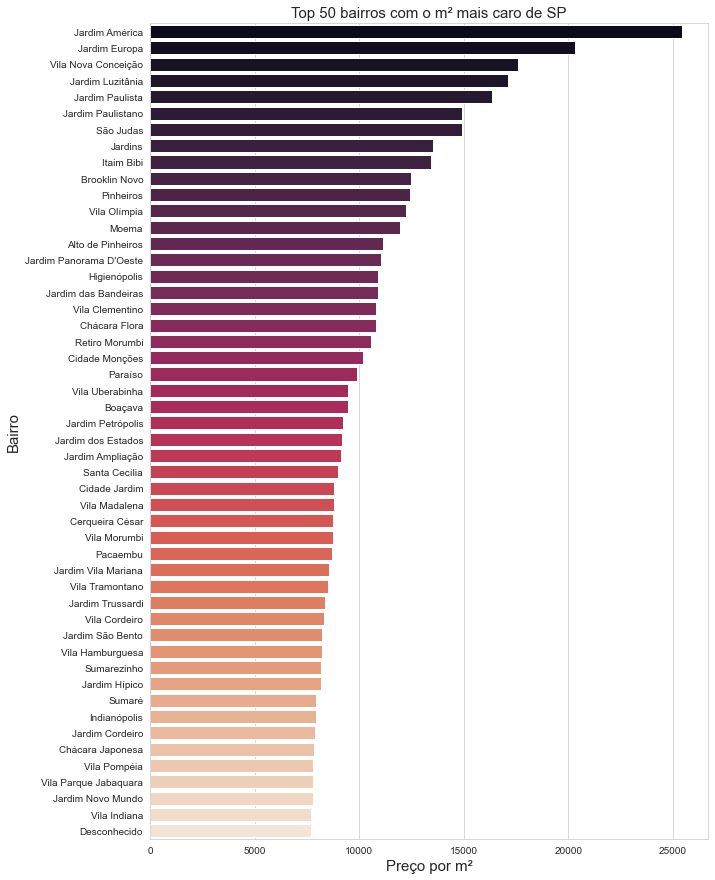

In [249]:
fonte = {"size":15}
plt.figure(figsize=(10,15))
sns.barplot(data=DF_copia2.head(50), x="Valor_M2", y=DF_copia2.head(50).index, palette="rocket")
plt.xlabel("Preço por m²", fontdict = fonte)
plt.ylabel("Bairro", fontdict = fonte)
plt.title("Top 50 bairros com o m² mais caro de SP", fontdict = fonte)
plt.show()

### Terceiro Problema:

<p>Aqui eu posso usar boxplot.</p>

In [257]:
#Faço uma terceira cópia do dataset para não afetar o "original";
DF_copia3=DF_copia.copy()

#Faço uma lista com os 5 bairros com os m² mais caros de SP;
indiceBairros = DF_copia2.head(50).index

#Mudo o índice do dataset para que ele seja o bairro;
DF_copia3.set_index("Bairro", inplace=True)

#Utilizo da lista para localizar os 50 bairros mais caros no dataframe!
DF_copia3.loc[indiceBairros]

,Rua,Cidade,Metragem,Quartos,Banheiros,Vagas,Valor,Valor_Bruto,Valor_Bruto_Milhoes
Bairro,,,,,,,,,
Jardim América,Rua Bolívia,São Paulo,663,4,7,6,R$ 14.500.000,14500000.0,14.500
Jardim América,"Rua Bolívia, 200",São Paulo,1060,4,5,9,R$ 11.489.000,11489000.0,11.489
Jardim América,Desconhecido,São Paulo,617,4,4,8,R$ 9.500.000,9500000.0,9.500
Jardim América,Rua Desembargador Vicente Penteado,São Paulo,410,4,6,3,R$ 5.200.000,5200000.0,5.200
Jardim América,Rua Panamá,São Paulo,950,4,4,6,R$ 26.000.000,26000000.0,26.000
...,...,...,...,...,...,...,...,...,...
Desconhecido,"Rua Alvorada do Sul, 3773",São Paulo,683,4,8,8,R$ 6.895.000,6895000.0,6.895
Desconhecido,"Rua Professor Eduardo Monteiro, 3773",São Paulo,555,3,5,6,R$ 4.000.000,4000000.0,4.000
Desconhecido,"Rua Professor Eduardo Monteiro, 3773",São Paulo,555,3,5,6,R$ 4.000.000,4000000.0,4.000


<AxesSubplot:xlabel='Valor_Bruto_Milhoes', ylabel='Bairro'>

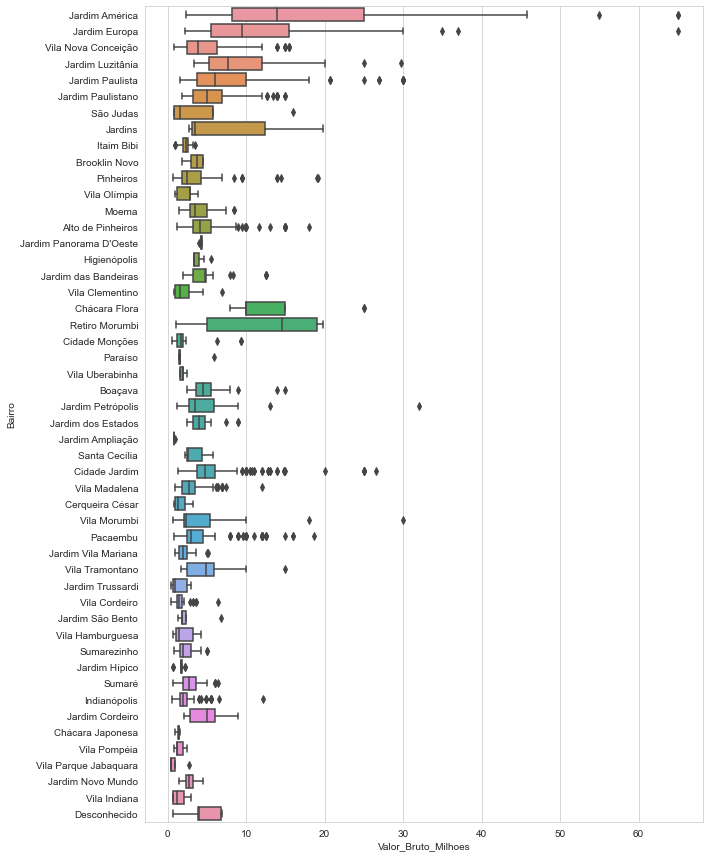

In [264]:
#Com a lista localizada, me resta apenas fazer o boxplot!

plt.figure(figsize=(10,15))
sns.boxplot(data=DF_copia3.loc[indiceBairros]
            ,y=DF_copia3.loc[indiceBairros].index,x="Valor_Bruto_Milhoes")

<p>Como podemos ver, existem outliers presentes no top 50. Além disso, podemos também ver que existem caixas muito pequenas, essas caixas podem indicar uma quantidade muito pequena de casas sendo vendidas, o que pode levar a conclusões errôneas ao analisarmos os dados. Aqui agora iria ser questão de conhecimento de negócio, que eu não tenho, para escolher quantas casas, no mínimo, seria um bom valor para ter uma ideia do valor das casas naquele bairro.</p>